# In progress

Note to self: draft things are marked with `======>`

======> Notes for reviewer:

*  If running the code, please adjust the value of `IMAGES_DIR` for your environment.

# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### Done: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

#
# All module imports for the project
#

import sys
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn, optim
import torchvision as tv
from PIL import Image

#
# Parameters
#

# Path to image dataset; must end with '/'
IMAGES_DIR = '../data/landmark_images/'

# Fraction of training images to use for validation
VALIDATION_FRAC = 0.2

# Width and height of input image in pixels after transforms
TRANSFORM_WIDTH_HEIGHT = 128

# Parametes for the color normalization step
# The choice for these parameters was informed by looking at the average
# mean and standard deviation from a random sample of images in the dataset.
#
TRANSFORM_MEAN = [0.5, 0.5, 0.5]
TRANSFORM_STD  = [0.25, 0.25, 0.25]

# Width of ignored border region in pixels, after scaling.
# Image is first resized to `TRANSFORM_WIDTH_HEIGHT + DISCARD_BORDER * 2`,
# then cropped to `TRANSFORM_WIDTH_HEIGHT`.
DISCARD_BORDER = 8

# Number of images in a batch
BATCH_SIZE = 32

# Number of image loading workers (0 = use main process)
NUM_LOADER_WORKERS = 2

#
# Transforms
#

# Image transform pipeline for training.
# Augment the training data by introducing some random transforms.
# ======>
#
train_transform = tv.transforms.Compose([
    tv.transforms.RandomResizedCrop(TRANSFORM_WIDTH_HEIGHT*1.2),
    tv.transforms.RandomRotation(degrees=10, interpolation=tv.transforms.InterpolationMode.BILINEAR),
    tv.transforms.CenterCrop(TRANSFORM_WIDTH_HEIGHT),
    tv.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.01),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=TRANSFORM_MEAN, std=TRANSFORM_STD)
])

# Deterministic image transform pipeline for validation and testing.
#
eval_transform = tv.transforms.Compose([
    tv.transforms.Resize(TRANSFORM_WIDTH_HEIGHT + DISCARD_BORDER * 2),
    tv.transforms.CenterCrop(TRANSFORM_WIDTH_HEIGHT),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=TRANSFORM_MEAN, std=TRANSFORM_STD)
])

#
# Datasets and samplers
#

# Training and testing datasets
train_dataset = tv.datasets.ImageFolder(IMAGES_DIR + 'train', transform=train_transform)
test_dataset  = tv.datasets.ImageFolder(IMAGES_DIR + 'test',  transform=eval_transform)

# Get the index to class mapping
classes_dict = train_dataset.classes

# Pick a random subset of the training images for validation
all_indices = list(range(len(train_dataset)))
np.random.shuffle(all_indices)
split = int(np.floor(len(train_dataset) * VALIDATION_FRAC))
valid_idx, train_idx = all_indices[:split], all_indices[split:]

# Define samplers for training and validation
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

# Remember the sizes of the training and validation sets.
# (`len(loader.dataset)` cannot be used; it does not take the samplers into account.)
train_dataset_size = len(train_sampler)
valid_dataset_size = len(valid_sampler)

#
# Image loaders
#

loaders_scratch = {
    'train': torch.utils.data.DataLoader(
        train_dataset,
        batch_size = BATCH_SIZE,
        sampler = train_sampler,
        num_workers = NUM_LOADER_WORKERS
    ),
    'valid': torch.utils.data.DataLoader(
        train_dataset,
        batch_size = BATCH_SIZE,
        sampler = valid_sampler,
        num_workers = NUM_LOADER_WORKERS
    ),
    'test': torch.utils.data.DataLoader(
        test_dataset,
        batch_size = BATCH_SIZE,
        num_workers = NUM_LOADER_WORKERS
    ),
}

# Print the dataset sizes (rounded up to a whole number of batches) for sanity checking
for name, loader in loaders_scratch.items():
    print(name + ":", BATCH_SIZE * len(loader))

train: 4000
valid: 1024
test: 1280


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:
~~~
======>
======>
======>
======>
======>
======>
======>
======>
~~~

======> Few images rotated 90dg; infeasible to fix (no EXIF data)

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

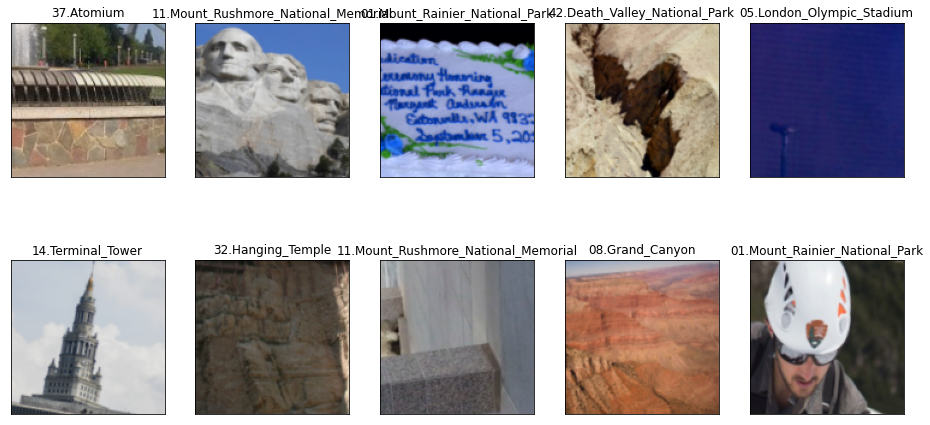

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Done: visualize a batch of the train data loader

PLOT_ROWS = 2
PLOT_COLUMNS = 5
PLOT_FIGURE_SIZE = (16, 8)

assert(PLOT_ROWS * PLOT_COLUMNS <= BATCH_SIZE)

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# Convert and plot an image on the current pyplot figure
# `image` is a numpy array with the inner 3 dimensions containing color, widht, and height respectively.
def plot_image(image):
    # Rearrange the dimensions from tensor (channels, width, height) to pyplot (width, height, channels).
    image = np.transpose(image, (1, 2, 0))
    # Reverse the color normalization
    image = image * TRANSFORM_STD + TRANSFORM_MEAN
    # Plot the image
    plt.imshow(image)

images, labels = iter(loaders_scratch['train']).next()
images = images.numpy()
fig = plt.figure(figsize=PLOT_FIGURE_SIZE)
for i in np.arange(PLOT_ROWS * PLOT_COLUMNS):
    ax = fig.add_subplot(PLOT_ROWS, PLOT_COLUMNS, i+1, xticks=(), yticks = ())
    plot_image(images[i])
    ax.set_title(classes_dict[labels[i]])

### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
## Done: select loss function
# Using negative log likelyhood loss, to match the log-softmax of the output
# ======>
criterion_scratch = nn.NLLLoss()

def get_optimizer_scratch(model):
    ## Done: select and return an optimizer
    # ======> Use Adam for now
    return optim.Adam(model.parameters(), lr=0.001)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    ## Done: choose an architecture, and complete the class
    
    # Convolutional layer stacks.
    #
    # Each entry in the list sets the number of features in each convolutional layer.
    # Each stack ends with a pooling layer.
    # ======>
    conv_stacks = [
        [8],
        [16],
        [32],
    ]
    
    # Classifier layers.
    #
    # Each number is the number of output nodes in a layer.
    # The final output layer must have nodes matching the number of classes in the dataset.
    # ======>
    class_layers = [2048, 512, 50]
    
    # Dropout probabilities
    # ======>
    DROPOUT_CONV = 0.2
    DROPOUT_FC = 0.3
    
    # Pooling layer; returns (new_size, module)
    def get_pool_layer(self, size):
        return size // 2, nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        )
    
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        
        # Create a `conv_module` sequence containing the convolutional layer stacks.
        #
        image_size = TRANSFORM_WIDTH_HEIGHT
        in_features = 3 # Start with 3 'features' (RGB color channels)
        stacks = []
        for stack in self.conv_stacks:
            layers = OrderedDict()
            
            for layer_i, out_features in enumerate(stack, start=1):
                name = f'l{layer_i}'
                # Convolutional layer
                layers[name + 'conv'] = nn.Conv2d(
                    in_channels = in_features,
                    out_channels = out_features,
                    kernel_size = 3,
                    padding = 1
                )
                # Set `in_features` for the next layer
                in_features = out_features
                # Activation function
                layers[name + 'act'] = nn.ReLU()
                
            # End the stack with a pooling layer.
            image_size, pool_layer = self.get_pool_layer(image_size)
            layers['pool'] = pool_layer
            
            stacks.append(nn.Sequential(layers))
        conv_module = nn.Sequential(*stacks)
        
        # `flatten_module` converts the output from the convolutional layers to a vector.
        #
        flatten_module = nn.Sequential(OrderedDict([
            ('drop', nn.Dropout2d(p=self.DROPOUT_CONV)),
            ('flatten', nn.Flatten(start_dim=1))
        ]))
        
        # Create a `classifier` module containing the fully connected layers.
        #
        in_nodes = in_features * image_size ** 2
        layers = OrderedDict()
        for layer_i, out_nodes in enumerate(self.class_layers, start=1):
            name = f'l{layer_i}'
            
            # Fully connected layer
            layers[name] = nn.Linear(in_nodes, out_nodes)
            # Set `in_nodes` for the next layer
            in_nodes = out_nodes
            
            # Use a LogSoftMax activation function for the final layer,
            # and ReLU plus dropout for the others.
            if layer_i < len(self.class_layers):
                layers[name + 'act'] = nn.ReLU()
                layers[name + 'drop'] = nn.Dropout(p=self.DROPOUT_FC)
            else:
                layers[name + 'act'] = nn.LogSoftmax(dim=1)
        classifier = nn.Sequential(layers)
        
        # Assemble the complete architecture.
        #
        self.architecture = nn.Sequential(OrderedDict([
            ('conv', conv_module),
            ('lin', flatten_module),
            ('fc', classifier)
        ]))
    
    def forward(self, x):
        ## Define forward behavior
        #
        # Only need to call the top-level sequential object;
        # it will iterate through all submodules.
        return self.architecture(x)

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__
======>

*   Starting state:
    ~~~
    conv_stacks = [
        [4, 8],
        [16],
        [32],
        [64],
    ]
    class_layers = [2048, 512, 50]
    DROPOUT_CONV = 0.2
    DROPOUT_FC = 0.3
    Optimizer: optim.Adam(model.parameters(), lr=0.001)
    
    Epoch:  1   Training Loss: 3.132060   Validation Loss: 0.782541
    Epoch: 20   Training Loss: 3.129436   Validation Loss: 0.783880
    ~~~
    Not enough room to train.
    
*   Increase size and number of layers
    ~~~
    conv_stacks = [
        [8, 16],
        [32, 64],
        [128],
        [256],
    ]
    class_layers = [4096, 2048, 512, 50]
    
    Epoch:  1   Training Loss: 3.132260   Validation Loss: 0.782744
    Epoch: 20   Training Loss: 3.129389   Validation Loss: 0.783828
    ~~~
    Virtually no progress.
    
*   Increase size again. Also remove all convolutional dropouts except the last one.
    ~~~
    conv_stacks = [
        [8, 16],
        [32, 64],
        [128, 256],
        [512],
    ]
    class_layers = [8192, 4096, 2048, 512, 50]
    ~~~
    Virtually no progress.
    
*   Maybe vanishing gradient.
    Back to first attempt, but with reduced number of layers. Keep single 2D dropout.
    ~~~
    conv_stacks = [
        [8],
        [16],
        [32],
    ]
    class_layers = [2048, 512, 50]
    
    Epoch: 20   Training Loss: 2.328805   Validation Loss: 0.586768
    ~~~
    Much better. Do weight init experiment, then continue with more epochs
    
    Best result:
    ~~~
    Epoch: 71   Training Loss: 1.715167   Validation Loss: 0.515695
    Test accuracy: 40%
    ~~~
    
*   Add colour randomization to the training image loader.
    Original:
    ~~~
    train_transform = tv.transforms.Compose([
        tv.transforms.RandomRotation(10),
        tv.transforms.RandomResizedCrop(TRANSFORM_WIDTH_HEIGHT),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean=TRANSFORM_MEAN, std=TRANSFORM_STD)
    ])
    ~~~
    
    New result:
    ~~~
    Epoch: 111   Training Loss: 1.561116   Validation Loss: 0.508853
    Test accuracy: 43%
    ~~~
    
*   Change std from 0.5 to 0.25 (final)

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss_accum = 0.0
        train_loss = 0.0
        valid_loss_accum = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## Done: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            # Reset gradients
            optimizer.zero_grad()
            
            # Compute the class predictions and loss
            log_ps = model(data)
            loss = criterion(log_ps, target)
            
            # Accumulate training loss.
            # The loss is an average for this batch, so multiply it with the batch size
            # to get a more accurate average loss for the whole dataset.
            train_loss_accum += loss.item() * data.size(0)
            
            # Perform an optimization step.
            loss.backward()
            optimizer.step()
            
        # Get the average training loss by dividing by the total number of images.
        # ======> fix counts
        train_loss = train_loss_accum / train_dataset_size

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()

                ## TODO: update average validation loss
                log_ps = model(data)
                loss = criterion(log_ps, target)
            
                # Accumulate validation loss.
                # The loss is an average for this batch, so multiply it with the batch size
                # to get a more accurate average loss for the whole dataset.
                valid_loss_accum += loss.item() * data.size(0)
                
        # Get the average validation loss by dividing by the total number of images.
        valid_loss = valid_loss_accum / valid_dataset_size

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## Done: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            print(f'\tValidation loss decreased: ({valid_loss_min:0.6f} -> {valid_loss:0.6f}); saving state.')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [7]:
def custom_weight_init(m):
    ## Done: implement a weight initialization strategy
    # Trying a normal distribution instead of uniform for the weights,
    # and very small uniform random values for the bias.
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        y = 1 / np.sqrt(m.weight.data.numel())
        m.weight.data.normal_(0, y)
        m.bias.data.uniform_(-0.01*y, 0.01*y)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.912699 	Validation Loss: 3.912958
	Validation loss decreased: (inf -> 3.912958); saving state.
Epoch: 2 	Training Loss: 3.912281 	Validation Loss: 3.913732
Epoch: 3 	Training Loss: 3.873538 	Validation Loss: 3.838961
	Validation loss decreased: (3.912958 -> 3.838961); saving state.
Epoch: 4 	Training Loss: 3.830197 	Validation Loss: 3.821625
	Validation loss decreased: (3.838961 -> 3.821625); saving state.
Epoch: 5 	Training Loss: 3.801555 	Validation Loss: 3.793501
	Validation loss decreased: (3.821625 -> 3.793501); saving state.
Epoch: 6 	Training Loss: 3.774312 	Validation Loss: 3.779195
	Validation loss decreased: (3.793501 -> 3.779195); saving state.
Epoch: 7 	Training Loss: 3.755155 	Validation Loss: 3.762484
	Validation loss decreased: (3.779195 -> 3.762484); saving state.
Epoch: 8 	Training Loss: 3.746543 	Validation Loss: 3.763653
Epoch: 9 	Training Loss: 3.730644 	Validation Loss: 3.738656
	Validation loss decreased: (3.762484 -> 3.738656); saving s

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [8]:
## Done: you may change the number of epochs if you'd like,
## but changing it is not required
# Both the training and validation loss still steadily decrease after 100 epochs.
# Maybe training for a bit longer can bring a small improvement.
num_epochs = 150

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.888066 	Validation Loss: 3.824912
	Validation loss decreased: (inf -> 3.824912); saving state.
Epoch: 2 	Training Loss: 3.761834 	Validation Loss: 3.707088
	Validation loss decreased: (3.824912 -> 3.707088); saving state.
Epoch: 3 	Training Loss: 3.655874 	Validation Loss: 3.604471
	Validation loss decreased: (3.707088 -> 3.604471); saving state.
Epoch: 4 	Training Loss: 3.575507 	Validation Loss: 3.581012
	Validation loss decreased: (3.604471 -> 3.581012); saving state.
Epoch: 5 	Training Loss: 3.498279 	Validation Loss: 3.538531
	Validation loss decreased: (3.581012 -> 3.538531); saving state.
Epoch: 6 	Training Loss: 3.449470 	Validation Loss: 3.372178
	Validation loss decreased: (3.538531 -> 3.372178); saving state.
Epoch: 7 	Training Loss: 3.403423 	Validation Loss: 3.378429
Epoch: 8 	Training Loss: 3.362354 	Validation Loss: 3.390633
Epoch: 9 	Training Loss: 3.285840 	Validation Loss: 3.334402
	Validation loss decreased: (3.372178 -> 3.334402); saving s

Epoch: 102 	Training Loss: 2.027196 	Validation Loss: 2.642414
Epoch: 103 	Training Loss: 1.986044 	Validation Loss: 2.677716
Epoch: 104 	Training Loss: 2.002792 	Validation Loss: 2.639335
Epoch: 105 	Training Loss: 1.965161 	Validation Loss: 2.674481
Epoch: 106 	Training Loss: 1.966483 	Validation Loss: 2.623057
Epoch: 107 	Training Loss: 1.994040 	Validation Loss: 2.689101
Epoch: 108 	Training Loss: 1.986643 	Validation Loss: 2.650952
Epoch: 109 	Training Loss: 1.966748 	Validation Loss: 2.642124
Epoch: 110 	Training Loss: 2.020617 	Validation Loss: 2.598515
	Validation loss decreased: (2.602060 -> 2.598515); saving state.
Epoch: 111 	Training Loss: 1.971465 	Validation Loss: 2.602488
Epoch: 112 	Training Loss: 1.901291 	Validation Loss: 2.689587
Epoch: 113 	Training Loss: 1.959054 	Validation Loss: 2.546489
	Validation loss decreased: (2.598515 -> 2.546489); saving state.
Epoch: 114 	Training Loss: 1.886621 	Validation Loss: 2.611452
Epoch: 115 	Training Loss: 1.942007 	Validation L

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [9]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.255908


Test Accuracy: 45% (569/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [1]:
### Done: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# ======> Repeat imports and constants, to allow this part to be run independently.
# ======> Temporary; remove
import sys
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn, optim
import torchvision as tv
from PIL import Image
IMAGES_DIR = '../data/landmark_images/'
VALIDATION_FRAC = 0.2
BATCH_SIZE = 32
NUM_LOADER_WORKERS = 2
use_cuda = torch.cuda.is_available()

#
# Updated parameters
#

# Width and height of input image in pixels after transforms
# 
TRANSFORM_WIDTH_HEIGHT = 224

# Parametes for the color normalization step.
# Match the parameters used for the pretrained Torchvision models.
#
TRANSFORM_MEAN = [0.485, 0.456, 0.406]
TRANSFORM_STD  = [0.229, 0.224, 0.225]

# Width of ignored border region in pixels, after scaling.
# Image is first resized to `TRANSFORM_WIDTH_HEIGHT + DISCARD_BORDER * 2`,
# then cropped to `TRANSFORM_WIDTH_HEIGHT`.
DISCARD_BORDER = 16

#
# Transforms
#

# Image transform pipeline for training.
# Augment the training data by introducing some random transforms.
# ======>
#
train_transform = tv.transforms.Compose([
    tv.transforms.RandomResizedCrop(TRANSFORM_WIDTH_HEIGHT*1.2),
    tv.transforms.RandomRotation(degrees=10, interpolation=tv.transforms.InterpolationMode.BILINEAR),
    tv.transforms.CenterCrop(TRANSFORM_WIDTH_HEIGHT),
    tv.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.01),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=TRANSFORM_MEAN, std=TRANSFORM_STD)
])

# Deterministic image transform pipeline for validation and testing.
#
eval_transform = tv.transforms.Compose([
    tv.transforms.Resize(TRANSFORM_WIDTH_HEIGHT + DISCARD_BORDER * 2),
    tv.transforms.CenterCrop(TRANSFORM_WIDTH_HEIGHT),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=TRANSFORM_MEAN, std=TRANSFORM_STD)
])

#
# Datasets and samplers
#

# Training and testing datasets
train_dataset = tv.datasets.ImageFolder(IMAGES_DIR + 'train', transform=train_transform)
test_dataset  = tv.datasets.ImageFolder(IMAGES_DIR + 'test',  transform=eval_transform)

# Get the index to class mapping
classes_dict = train_dataset.classes

# Pick a random subset of the training images for validation
all_indices = list(range(len(train_dataset)))
np.random.shuffle(all_indices)
split = int(np.floor(len(train_dataset) * VALIDATION_FRAC))
valid_idx, train_idx = all_indices[:split], all_indices[split:]

# Define samplers for training and validation
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

train_dataset_size = len(train_sampler)
valid_dataset_size = len(valid_sampler)

#
# Image loaders
#

loaders_transfer = {
    'train': torch.utils.data.DataLoader(
        train_dataset,
        batch_size = BATCH_SIZE,
        sampler = train_sampler,
        num_workers = NUM_LOADER_WORKERS
    ),
    'valid': torch.utils.data.DataLoader(
        train_dataset,
        batch_size = BATCH_SIZE,
        sampler = valid_sampler,
        num_workers = NUM_LOADER_WORKERS
    ),
    'test': torch.utils.data.DataLoader(
        test_dataset,
        batch_size = BATCH_SIZE,
        num_workers = NUM_LOADER_WORKERS
    ),
}

# Print the dataset sizes (rounded up to whole batch) for sanity checking
for name, loader in loaders_transfer.items():
    print(name + ":", BATCH_SIZE * len(loader))

train: 4000
valid: 1024
test: 1280


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [5]:
## Done: select loss function
criterion_transfer = nn.NLLLoss()

def get_optimizer_transfer(model):
    ## Done: select and return optimizer
    #
    # The Adam algorithm doesn't seem to work well in this scenario; it converges very slowly.
    # Use a straightforward stochastic gradient descent instead.
    #
    # Only optimize the `classifier` parameters; the other parameters are fixed.
    #
    return optim.SGD(model.classifier.parameters(), lr=0.001)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [6]:
## Done: Specify model architecture

# Start with a pretrained VGG19 model with batch normalization.
# Disable gradients for all parameters of the "features" module, as they are not needed.
model_transfer = tv.models.vgg19_bn(pretrained=True)
for p in model_transfer.features.parameters():
    p.requires_grad = False

# Replace the classifier output layer with a new layer containing the required number of output nodes.
# Use Log-Softmax as the activation function.
model_transfer.classifier[6] = nn.Linear(in_features=4096, out_features=50)
model_transfer.classifier.add_module('7', nn.LogSoftmax(dim=1))

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__
======>

*   Starting state:
    * VGG19 with batch normalization
    * replace output layer; 50 outputs and re-initialized parameters
    * classifier part is trained, starting from pretrained parameters for all hidden layers
    * other parts stay at pretrained state
    * best alternative of 4:
      1. replace last layer, start from pretrained weights (best result after 20 epochs);
      2. add new layer, start from pretrained weights;
      3. replace last layer, start from random weights;
      4. add new layer, start from random weights.
    
*   Adam --> SGD

Results from parallel test:
~~~
EPOCH  Replace               Add                   Replace_Init          Add_Init            
=====  ====================  ====================  ====================  ====================
    1  T: 2.9141  V: 2.0743  T: 2.6583  V: 1.8518  T: 3.8947  V: 3.8693  T: 3.9108  V: 3.9079
    2  T: 1.9248  V: 1.6494  T: 1.8844  V: 1.6428  T: 3.8466  V: 3.8044  T: 3.9065  V: 3.9036
    3  T: 1.6253  V: 1.5255  T: 1.6820  V: 1.5342  T: 3.7630  V: 3.6822  T: 3.9011  V: 3.8970
    4  T: 1.4782  V: 1.4590  T: 1.5425  V: 1.5186  T: 3.6115  V: 3.4754  T: 3.8930  V: 3.8881
    5  T: 1.4067  V: 1.3085  T: 1.4519  V: 1.3271  T: 3.3480  V: 3.1381  T: 3.8811  V: 3.8694
    6  T: 1.3187  V: 1.2707  T: 1.3800  V: 1.3198  T: 3.0343  V: 2.8126  T: 3.8608  V: 3.8405
    7  T: 1.2930  V: 1.2337  T: 1.3409  V: 1.2733  T: 2.7328  V: 2.5337  T: 3.8265  V: 3.7944
    8  T: 1.2253  V: 1.2319  T: 1.2739  V: 1.2591  T: 2.5140  V: 2.3092  T: 3.7742  V: 3.7307
    9  T: 1.1999  V: 1.1631  T: 1.2465  V: 1.2210  T: 2.3242  V: 2.1399  T: 3.7016  V: 3.6334
   10  T: 1.1443  V: 1.1790  T: 1.1886  V: 1.2042  T: 2.1252  V: 2.0319  T: 3.5858  V: 3.4862
   11  T: 1.1208  V: 1.2409  T: 1.1515  V: 1.2708  T: 2.0082  V: 1.9012  T: 3.4239  V: 3.2813
   12  T: 1.0743  V: 1.1660  T: 1.1168  V: 1.2037  T: 1.8825  V: 1.7865  T: 3.1958  V: 3.0195
   13  T: 1.0544  V: 1.1651  T: 1.0917  V: 1.2089  T: 1.7823  V: 1.7332  T: 2.9857  V: 2.8347
   14  T: 1.0527  V: 1.1493  T: 1.0777  V: 1.1933  T: 1.7206  V: 1.6582  T: 2.8220  V: 2.6379
   15  T: 1.0441  V: 1.1402  T: 1.0893  V: 1.1759  T: 1.6529  V: 1.6186  T: 2.6749  V: 2.5094
   16  T: 1.0014  V: 1.1174  T: 1.0527  V: 1.1731  T: 1.5927  V: 1.5302  T: 2.5521  V: 2.3689
   17  T: 0.9699  V: 1.1262  T: 1.0231  V: 1.1933  T: 1.5203  V: 1.5139  T: 2.4216  V: 2.2933
   18  T: 0.9422  V: 1.1232  T: 0.9805  V: 1.1744  T: 1.4533  V: 1.4857  T: 2.2868  V: 2.1804
   19  T: 0.9869  V: 1.1721  T: 1.0182  V: 1.2319  T: 1.4670  V: 1.5338  T: 2.2193  V: 2.1424
   20  T: 0.9364  V: 1.1368  T: 0.9406  V: 1.1705  T: 1.3698  V: 1.4482  T: 2.0885  V: 1.9908
~~~

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [7]:
# Done: train the model and save the best model parameters at filepath 'model_transfer.pt'

EPOCHS = 100

# Keep all components in evaluation mode, except for the classifier.
model_transfer.eval()

optimizer = get_optimizer_transfer(model_transfer)
valid_loss_min = np.Inf

for epoch in range(1, EPOCHS+1):
    train_loss_accum = 0.0
    valid_loss_accum = 0.0
    
    # Training loop
    #
    model_transfer.classifier.train()
    for data, target in loaders_transfer['train']:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        log_ps = model_transfer(data)
        loss = criterion_transfer(log_ps, target)
        train_loss_accum += loss.item() * data.size(0)
        loss.backward()
        optimizer.step()
        
    # Validation loop
    #
    model_transfer.classifier.eval()
    with torch.no_grad():
        for data, target in loaders_transfer['valid']:
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            log_ps = model_transfer(data)
            loss = criterion_transfer(log_ps, target)
            valid_loss_accum += loss.item() * data.size(0)
    
    # Show status; save parameters if validation loss has decreased.
    #
    train_loss = train_loss_accum / train_dataset_size
    valid_loss = valid_loss_accum / valid_dataset_size
    print(f"Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}")
    if valid_loss < valid_loss_min:
        print(f'\tValidation loss decreased: ({valid_loss_min:0.6f} -> {valid_loss:0.6f}); saving state.')
        torch.save(model_transfer.state_dict(), 'model_transfer.pt')
        valid_loss_min = valid_loss

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.834016 	Validation Loss: 3.646005
	Validation loss decreased: (inf -> 3.646005); saving state.
Epoch: 2 	Training Loss: 3.536285 	Validation Loss: 3.383526
	Validation loss decreased: (3.646005 -> 3.383526); saving state.
Epoch: 3 	Training Loss: 3.276344 	Validation Loss: 3.145899
	Validation loss decreased: (3.383526 -> 3.145899); saving state.
Epoch: 4 	Training Loss: 3.034272 	Validation Loss: 2.918856
	Validation loss decreased: (3.145899 -> 2.918856); saving state.
Epoch: 5 	Training Loss: 2.827094 	Validation Loss: 2.725881
	Validation loss decreased: (2.918856 -> 2.725881); saving state.
Epoch: 6 	Training Loss: 2.646069 	Validation Loss: 2.543798
	Validation loss decreased: (2.725881 -> 2.543798); saving state.
Epoch: 7 	Training Loss: 2.470204 	Validation Loss: 2.398248
	Validation loss decreased: (2.543798 -> 2.398248); saving state.
Epoch: 8 	Training Loss: 2.334278 	Validation Loss: 2.251254
	Validation loss decreased: (2.398248 -> 2.251254); sav

Epoch: 92 	Training Loss: 1.076825 	Validation Loss: 1.249939
Epoch: 93 	Training Loss: 1.067549 	Validation Loss: 1.229787
Epoch: 94 	Training Loss: 1.058557 	Validation Loss: 1.231089
Epoch: 95 	Training Loss: 1.056650 	Validation Loss: 1.236455
Epoch: 96 	Training Loss: 1.055293 	Validation Loss: 1.281991
Epoch: 97 	Training Loss: 1.078528 	Validation Loss: 1.251302
Epoch: 98 	Training Loss: 1.040133 	Validation Loss: 1.249368
Epoch: 99 	Training Loss: 1.021477 	Validation Loss: 1.204028
	Validation loss decreased: (1.219266 -> 1.204028); saving state.
Epoch: 100 	Training Loss: 1.024872 	Validation Loss: 1.236407


<All keys matched successfully>

In [8]:
# ======> TEMPORARY CELL
# ======> Repeat the `test` function from above
# ======>
# ======>

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [9]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.840789


Test Accuracy: 79% (989/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [ ]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [ ]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

